### Науменко Константин, MADE CV
- В данной работе обучена модель классификации вида спорта по фотографии.
- Первая попытка с моделью `se-resnext101` дала неудовлитворительный результат с accuracy ~80%.
- Текущая модель - ViT с двумя линейными слоями в классификаторе с легкостью добивается 90% без какой-нибудь серьезной работы с датасетом, даже аугментация не проводилась.
- Для повышения качества необходима скурпулезная работа с данными, выделение плохих примеров, ошибок в классификации, увеличение датасета и т.д.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Pad, Resize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from torchvision.io import read_image
from tqdm import tqdm, tqdm_notebook
import PIL
from IPython import display 
import torch.optim as optim


In [2]:
INPUT_DIR = '/kaggle/input/vk-made-sports-image-classification'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [3]:
! ls $INPUT_DIR

test  test.csv	train  train.csv


In [4]:
df_test = pd.read_csv(INPUT_DIR + '/test.csv')
df_train = pd.read_csv(INPUT_DIR + '/train.csv')

In [5]:
df_train.iloc[0, 1]

'swimming'

In [6]:
name2ind = {name: i for i, name in enumerate(df_train['label'].value_counts().index.values)}
ind2name = {ind: name for name, ind in name2ind.items()}


In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_csv, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_csv
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        image = PIL.Image.open(img_path)
        image = image.convert('RGB')
        image = transforms.ToTensor()(image)
        image = self._pad(image)
        
        label = self.img_labels.iloc[idx, 1]
        label = name2ind[label]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
    @staticmethod
    def _pad(image):
        "Make image square"
        width = image.shape[1]
        height = image.shape[2]
        if width > height:
            image = Pad([width - height, 0])(image)
        elif width < height:
            image = Pad([0, height - width])(image)
        return image.float()
            

In [8]:
TRAIN_CSV = INPUT_DIR + '/train.csv'
TRAIN_DIR = INPUT_DIR + '/train'
TEST_CSV = INPUT_DIR + '/test.csv'
TEST_DIR = INPUT_DIR + '/test'

test_csv = pd.read_csv(TEST_CSV)
train_csv = pd.read_csv(TRAIN_CSV)
train_csv, val_csv = train_test_split(train_csv, test_size=0.2, random_state=42, shuffle=True)



transform = transforms.Compose([
#             transforms.ToTensor(),
            transforms.Resize((384, 384)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
train_data = CustomImageDataset(train_csv, TRAIN_DIR, transform)
val_data = CustomImageDataset(val_csv, TRAIN_DIR, transform)
test_data = CustomImageDataset(test_csv, TEST_DIR, transform)

train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False)

In [9]:
batch = next(iter(train_dataloader))
batch[0].shape, batch[1]

(torch.Size([256, 3, 384, 384]),
 tensor([13,  9,  8,  6, 26,  5, 10, 11,  3, 11,  7,  5, 10, 22, 12, 10, 24, 13,
         14, 21,  5,  1, 20, 18,  0,  0, 27, 18, 11, 11,  9, 12, 24, 17, 10,  3,
         18,  4,  0,  6, 27,  6, 11,  8,  3, 19, 18, 22,  9, 24,  0,  0,  1,  8,
         21,  8, 11, 11, 26,  9,  9, 15, 10, 18,  3, 28,  5, 10, 10,  6, 13,  0,
         25, 10, 19, 18, 10, 26, 23, 26,  7,  9, 10, 15, 11,  7, 26, 16,  5,  0,
         16, 20, 28, 20, 10,  5, 21, 25, 22,  7,  8, 16,  8,  2, 23,  0, 26, 13,
          9,  7, 15, 12, 26,  5, 13,  0, 16,  0, 13, 18, 18, 19,  9,  3,  2,  2,
          6, 23, 19, 16,  4, 29, 14,  7, 11, 25, 28,  2,  1, 26,  6, 25,  6,  1,
         24,  1,  0, 18, 18,  8,  7, 19, 17,  7, 27,  0, 16,  2,  7,  7, 20, 23,
         27, 15, 18, 20, 26, 14, 10,  0,  9, 18, 27,  1, 13, 10, 13,  1, 18, 18,
          4, 16, 14,  3,  8, 12, 18,  9, 15,  8,  9, 10, 27, 11, 16,  1,  6,  9,
          1,  7, 22,  6,  2, 10, 13,  8,  0, 19, 17, 23, 25,  6, 11,  3,  2,

  0%|          | 0/45373 [00:00<?, ?it/s]


swimming


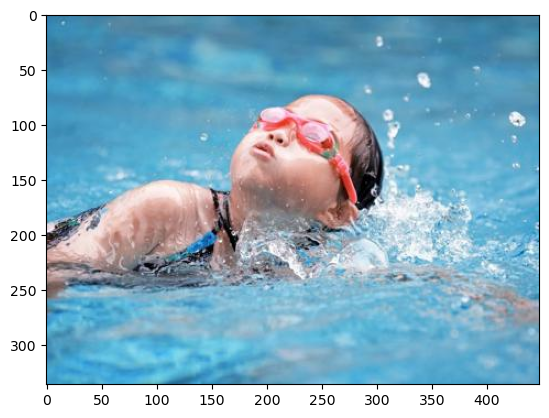

In [13]:
train_csv = pd.read_csv(TRAIN_CSV)
for i in tqdm(range(train_csv.shape[0])):
    img_path = os.path.join(TRAIN_DIR, train_csv.iloc[i, 0])
    im = read_image(img_path)
#     im = CustomImageDataset._pad(im)
    im_shape = im.shape
    print(train_csv.iloc[i, 1])
    plt.imshow(im.permute((1, 2, 0)).int())
    break

In [14]:
def plot_loss(train_loss, train_history, val_history, acc_history):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax[0].plot(train_history, label='train_history')
    ax[0].plot(val_history, label='val_history')
    ax[1].plot(acc_history, label='acc_history')
    ax[2].plot(train_loss, label='train_loss')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[2].set_xlabel('Batches')
    ax[2].set_ylabel('Loss')    
    plt.show()

In [21]:
def train_epoch(model, train_loader, val_loader, optimizer, criterion, train_history, val_history, acc_history):
    train_loss_epoch = []
    val_loss_epoch = []
    model.train()
    running_corrects = 0
    processed_size = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Train 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        train_loss_epoch.append(loss.cpu().detach().numpy())
        
        if i % 10 == 1:
            display.clear_output(True)
            plot_loss(train_loss_epoch, train_history, val_history, acc_history)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            # validate
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            val_loss_epoch.append(loss.cpu().detach().numpy())
            
            running_corrects += torch.sum(preds == labels.data)
            processed_size += inputs.size(0)
    
    train_loss = torch.FloatTensor(np.array(train_loss_epoch)).mean()
    val_loss = torch.FloatTensor(np.array(val_loss_epoch)).mean()
    val_acc = running_corrects.double() / processed_size
    return train_loss, val_loss, val_acc


def main(model, train_loader, val_loader, epochs=8):
    train_history = []
    val_history = []
    acc_history = []
    
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.5, 0.999))
    sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss, val_loss, val_acc = train_epoch(model, train_loader, val_loader, optimizer,
                                                    criterion, train_history, val_history, acc_history)
        sheduler.step()
        train_history.append(train_loss.cpu().detach().numpy())
        val_history.append(val_loss.cpu().detach().numpy())
        acc_history.append(val_acc.cpu().detach().numpy())

In [16]:
def test(model, test_csv, im_size=384):

    def get_image(img_path):
        image = PIL.Image.open(img_path)
        image = image.convert('RGB')
        image = transforms.ToTensor()(image)

        width = image.shape[1]
        height = image.shape[2]
        
        if width > height:
            image = Pad([width - height, 0])(image)
        elif width < height:
            image = Pad([0, height - width])(image)
        return image.float()

    model.eval()
    result = []
    with torch.no_grad():
        for i in tqdm(range(test_csv.shape[0])):
            img_path = os.path.join(TEST_DIR, test_csv.iloc[i, 0])
            image = get_image(img_path)
            image = transforms.Resize((im_size, im_size))(image)
            image = image.to(DEVICE).unsqueeze(0)
            outputs = model(image)
            preds = torch.argmax(outputs, 1)
            result.append(ind2name[preds.detach().cpu().numpy()[0]])
    return result

In [19]:
model = models.vit_b_16('ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1')
for param in model.parameters():
    param.requires_grad = False
model.heads.head = nn.Sequential(nn.Linear(768, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 30))

In [20]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

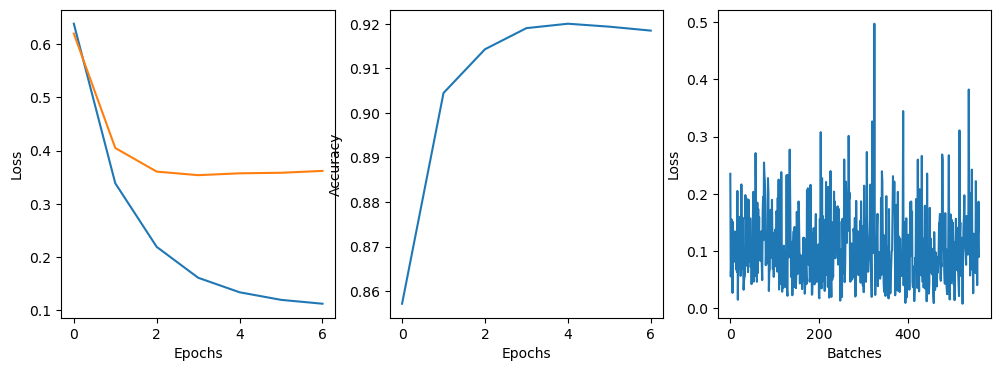

In [22]:
main(model, train_dataloader, val_dataloader)

In [154]:
result = test(model, test_csv, im_size=384)

100%|██████████| 19446/19446 [10:03<00:00, 32.22it/s]


In [156]:
solution = test_csv.copy()
solution['label'] = result
solution.to_csv('prediction_4.csv', index=False)
solution.head()

,image_id,label
0,00fd3c23-193c-480a-aef9-bb438d50d79e.jpeg,ski_race
1,ef5473b9-a558-4f38-acd0-be4ecfde5a23.jpeg,basketball
2,ba00f9b4-7cbf-4110-91ea-ed41f5cb4ee4.jpeg,alpinism
3,f1bdf877-4379-4e00-b5b8-1e90bdcbda76.jpeg,tennis
4,4c96ff83-07e3-45a4-934f-a92ebf49b299.jpeg,fencing
